In [1]:
%matplotlib inline

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from datetime import datetime
import scipy.stats as stats
from bokeh.io import output_notebook
output_notebook()
from bokeh.transform import linear_cmap
from bokeh.palettes import Plasma256 as palette
from bokeh.models import ColorBar
from bokeh.models import ColumnDataSource
import matplotlib.dates as mdates
from config import gmaps_api_key
from bokeh.io import show, export_png, save
from bokeh.plotting import gmap, output_file
from bokeh.models import GMapOptions

Loading BokehJS ...

In [3]:
crime_data = pd.read_csv('Crime_Data_from_2020_to_present.csv')

In [4]:
#format time properly
times = []
for time in crime_data['TIME OCC']:
    time_str = str(time)
    if len(time_str) == 1:
        converted_time = f"00:0{time_str[-1]}:00"
    elif len(time_str) == 2:
        converted_time = f"00:{time_str[-2:]}:00"
    elif len(time_str) == 3:
        converted_time = f"0{time_str[-3]}:{time_str[-2:]}:00"
    else:
        converted_time = f"{time_str[-4:-2]}:{time_str[-2:]}:00"
    times.append(converted_time)
crime_data['dt'] = pd.to_datetime(pd.to_datetime(crime_data['DATE OCC']).astype(str) + ' ' + times)

In [5]:
#remove unneeded rows
crime_df = crime_data.drop(['DR_NO','Date Rptd','Crm Cd','Crm Cd 1','Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4','Part 1-2','Mocodes','Premis Cd', 
        'Premis Desc','Weapon Used Cd', 'Weapon Desc','Cross Street','Status', 'Status Desc','Rpt Dist No','DATE OCC'], axis=1,)
crime_df

,TIME OCC,AREA,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LOCATION,LAT,LON,dt
0,2230,3,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,1100 W 39TH PL,34.0141,-118.2978,2020-01-08 22:30:00
1,330,1,Central,BATTERY - SIMPLE ASSAULT,25,M,H,700 S HILL ST,34.0459,-118.2545,2020-01-01 03:30:00
2,1200,1,Central,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,200 E 6TH ST,34.0448,-118.2474,2020-02-13 12:00:00
3,1730,15,N Hollywood,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,5400 CORTEEN PL,34.1685,-118.4019,2020-01-01 17:30:00
4,415,19,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,14400 TITUS ST,34.2198,-118.4468,2020-01-01 04:15:00
...,...,...,...,...,...,...,...,...,...,...,...
761577,1800,16,Foothill,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",23,M,H,12500 BRANFORD ST,34.2466,-118.4054,2023-01-26 18:00:00
761578,1000,16,Foothill,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",25,F,H,12800 FILMORE ST,34.2790,-118.4116,2023-03-22 10:00:00
761579,1630,12,77th Street,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",29,M,B,6100 S VERMONT AV,33.9841,-118.2915,2023-04-12 16:30:00
761580,1,1,Central,PICKPOCKET,24,F,H,500 S MAIN ST,34.0467,-118.2485,2023-07-01 00:01:00


In [6]:
#classify crime types
violent = ['BATTERY - SIMPLE ASSAULT','RAPE, FORCIBLE', 
           'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
           'INTIMATE PARTNER - SIMPLE ASSAULT',
           'INTIMATE PARTNER - AGGRAVATED ASSAULT','BATTERY WITH SEXUAL CONTACT',
           'BATTERY POLICE (SIMPLE)','OTHER ASSAULT',
           'SEXUAL PENETRATION W/FOREIGN OBJECT','SHOTS FIRED AT INHABITED DWELLING',
           'ORAL COPULATION','ATTEMPTED ROBBERY','ROBBERY','BRANDISH WEAPON',
           'CHILD STEALING','KIDNAPPING - GRAND ATTEMPT','KIDNAPPING',
           'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ',
           'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
           'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT','RAPE, ATTEMPTED',
           'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT','CRIMINAL HOMICIDE',
           'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
           'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS','BATTERY ON A FIREFIGHTER',
           'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
           'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE','LYNCHING - ATTEMPTED',
           'MANSLAUGHTER, NEGLIGENT','WEAPONS POSSESSION/BOMBING','LYNCHING',
           'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
           'CRIMINAL THREATS - NO WEAPON DISPLAYED','THREATENING PHONE CALLS/LETTERS']
property = ['VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
            'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
            'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
            'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
            'ARSON','THEFT PLAIN - PETTY ($950 & UNDER)', 
            'THEFT OF IDENTITY','BURGLARY', 'VEHICLE - STOLEN',
            'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)','BUNCO, GRAND THEFT', 
            'THEFT, PERSON','BIKE - STOLEN','BURGLARY FROM VEHICLE',
            'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
            'THEFT FROM MOTOR VEHICLE - ATTEMPT','THROWING OBJECT AT MOVING VEHICLE',
            'EXTORTION','BURGLARY, ATTEMPTED',
            'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
            'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)','PURSE SNATCHING',
            'THEFT PLAIN - ATTEMPT','SHOPLIFTING - ATTEMPT',
            'THEFT FROM PERSON - ATTEMPT','BURGLARY FROM VEHICLE, ATTEMPTED',
            'VEHICLE - ATTEMPT STOLEN','EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
            'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER',
            'CREDIT CARDS, FRAUD USE ($950 & UNDER','PICKPOCKET',
            'DOCUMENT WORTHLESS ($200 & UNDER)',
            'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01',
            'DISHONEST EMPLOYEE - GRAND THEFT','TILL TAP - PETTY ($950 & UNDER)',
            'TILL TAP - GRAND THEFT ($950.01 & OVER)',
            'DOCUMENT WORTHLESS ($200.01 & OVER)',
            'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
            'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)',
            'PETTY THEFT - AUTO REPAIR','PURSE SNATCHING - ATTEMPT',
            'BIKE - ATTEMPTED STOLEN','BOAT - STOLEN',
            'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)',
            'GRAND THEFT / INSURANCE FRAUD', 'DISHONEST EMPLOYEE - PETTY THEFT',
            'THEFT, COIN MACHINE - ATTEMPT',
            'THEFT, COIN MACHINE - PETTY ($950 & UNDER)','GRAND THEFT / AUTO REPAIR',
            'PICKPOCKET, ATTEMPT','TELEPHONE PROPERTY - DAMAGE',
            'DISHONEST EMPLOYEE ATTEMPTED THEFT','TRESPASSING']
other = ['SEX OFFENDER REGISTRANT OUT OF COMPLIANCE','OTHER MISCELLANEOUS CRIME',
         'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD','VIOLATION OF COURT ORDER', 
         'VIOLATION OF RESTRAINING ORDER', 'DISTURBING THE PEACE',
         'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)','BOMB SCARE',
         'DOCUMENT FORGERY / STOLEN FELONY', 'INDECENT EXPOSURE',
         'VIOLATION OF TEMPORARY RESTRAINING ORDER','RESISTING ARREST',
         'DISCHARGE FIREARMS/SHOTS FIRED', 
         'LEWD/LASCIVIOUS ACTS WITH CHILD', 'LEWD CONDUCT',
         'UNAUTHORIZED COMPUTER ACCESS','CHILD NEGLECT (SEE 300 W.I.C.)', 
         'CONTEMPT OF COURT','CHILD ANNOYING (17YRS & UNDER)', 'BUNCO, ATTEMPT',
         'PIMPING', 'STALKING','FALSE IMPRISONMENT','FAILURE TO YIELD','COUNTERFEIT',
         'PROWLER','CHILD PORNOGRAPHY','PEEPING TOM','FIREARMS RESTRAINING ORDER (FIREARMS RO)',
         'DRIVING WITHOUT OWNER CONSENT (DWOC)','CRUELTY TO ANIMALS','FALSE POLICE REPORT', 
         'PANDERING', 'ILLEGAL DUMPING','RECKLESS DRIVING','CONSPIRACY', 'CONTRIBUTING',
         'BRIBERY','DISRUPT SCHOOL','REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
         'DRUGS, TO A MINOR','DRUNK ROLL', 'CHILD ABANDONMENT','BIGAMY', 'FAILURE TO DISPERSE',
         'FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)',
         'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
         'BLOCKING DOOR INDUCTION CENTER', 'INCITING A RIOT']

In [7]:
#add crime type column
type = []
for index, row in crime_df.iterrows():
    if row['Crm Cd Desc'] in violent:
        type.append('violent')
    elif row['Crm Cd Desc'] in property:
        type.append('property')
    else:
        type.append('other')
crime_df['type'] = type

## Brief Analyses of Overall Crime Types, Victim Gener, Ethnicity, and Age in LA

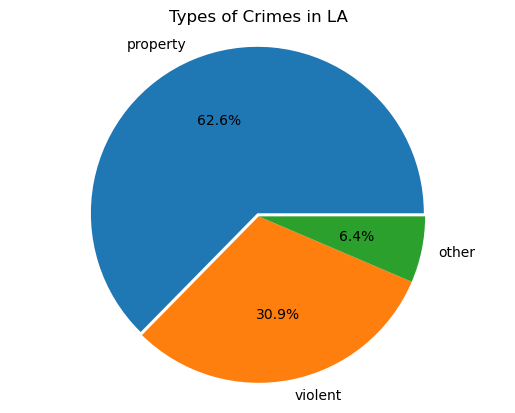

In [ ]:
# pie chart for crime type in LA crime
crime = crime_df [ 'type'].value_counts()
labels = crime.index.values
plt.pie(crime, labels=labels, explode = (0.02,0,0), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Types of Crimes in LA')
plt.show()

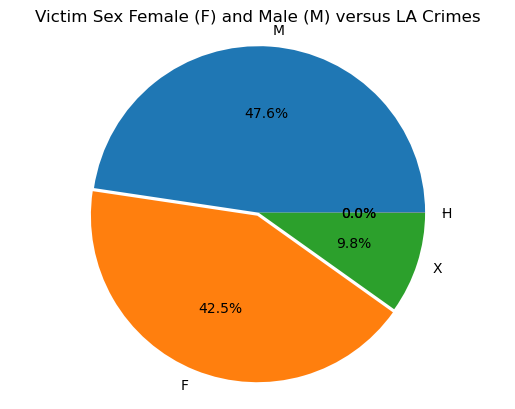

In [ ]:
# pie chart to take a look at the Vict gender in LA crime
sex = crime_df['Vict Sex'].value_counts()
labels = sex.index.values
plt.pie(sex,explode = (0,0.02,0,0,0),labels=labels,
         autopct="%1.1f%%")
plt.title('Victim Sex Female (F) and Male (M) versus LA Crimes')
plt.axis("equal")            
plt.show()

In [ ]:
# pice chart to take a look at victim ethnicity in LA crime
# looks at Victim Ethnicity
descent = crime_df['Vict Descent'].value_counts()
descent

H    233935
W    156128
B    109245
X     72183
O     60284
A     16635
K      4053
F      3174
C      2864
J      1070
V       771
I       730
Z       370
P       207
U       157
D        53
G        51
L        47
S        44
-         2
Name: Vict Descent, dtype: int64

In [ ]:
# the top 5 victim ethnicity
top5= descent[:5].copy()

# others victim ethnicity lump sum
others = descent[5:].sum()
others_s = pd.Series(others, index=['others'])

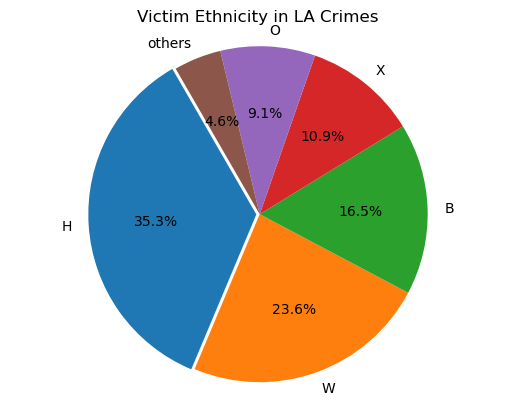

In [ ]:
# pie chart for victim ethnicity in LA crimes
concat_df = pd.concat([top5, others_s])
concat_df
plt.pie(concat_df, labels=concat_df.index.values, explode= (0.02,0,0,0,0,0), autopct='%1.1f%%', startangle=120)
plt.axis('equal')
plt.title('Victim Ethnicity in LA Crimes')
plt.show()

In [ ]:
# look at numbers of each type of crimes in LA
numb_crimes = crime_df['type'].value_counts()
numb_crimes

property    477046
violent     235572
other        48964
Name: type, dtype: int64

In [ ]:
# # group by crime type and victim sex to see what type of crime 
# # associated with what type of vict sex
# vict_ethni_crimes = crime_df.groupby(['type','Vict Sex'])['Vict Sex'].count()
# vict_ethni_crimes.sort_values()

type      Vict Sex
other     H                1
property  -                1
violent   H               25
property  H               62
other     X             6417
violent   X             7917
other     M            15642
          F            26863
property  X            50811
violent   F           111076
          M           116426
property  F           143437
          M           183331
Name: Vict Sex, dtype: int64

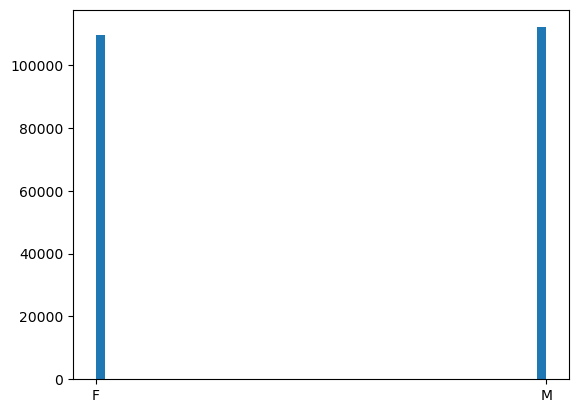

30

In [75]:
#analyze crime variation by age and sex
age_sex_df = crime_df[((crime_df['Vict Sex'] == 'M') | (crime_df['Vict Sex'] == 'F')) & (crime_df['Vict Age'] > 0)]
age_sex_df['Vict Descent'].value_counts()
as_type_df = age_sex_df[ (age_sex_df['type'] == 'violent')]#[age_sex_df['type'] == 'property']
#plt.hist(age_sex_df['Vict Age'],8)
plt.hist(as_type_df['Vict Sex'],49)
#plt.hist(age_sex_df['Vict Age'],98)
plt.show()
#men and women equal for violent, more men for property, significantly more women for other
statistics.mode(as_type_df['Vict Age'])

In [76]:
#calculate male to female and female to male ratios by crime description
f_desc = age_sex_df.loc[age_sex_df['Vict Sex'] == 'F','Crm Cd Desc'].value_counts()#[0:70]
m_desc = age_sex_df.loc[age_sex_df['Vict Sex'] == 'M','Crm Cd Desc'].value_counts()#[0:70]


findex_list = list(f_desc.index)
for type in f_desc.index:
    if type not in m_desc.index:
        findex_list.remove(type)    
fm_ratio = f_desc / m_desc[findex_list]

mindex_list = list(m_desc.index)
for type in m_desc.index:
    if type not in f_desc.index:
        mindex_list.remove(type)
mf_ratio = m_desc / f_desc[mindex_list]

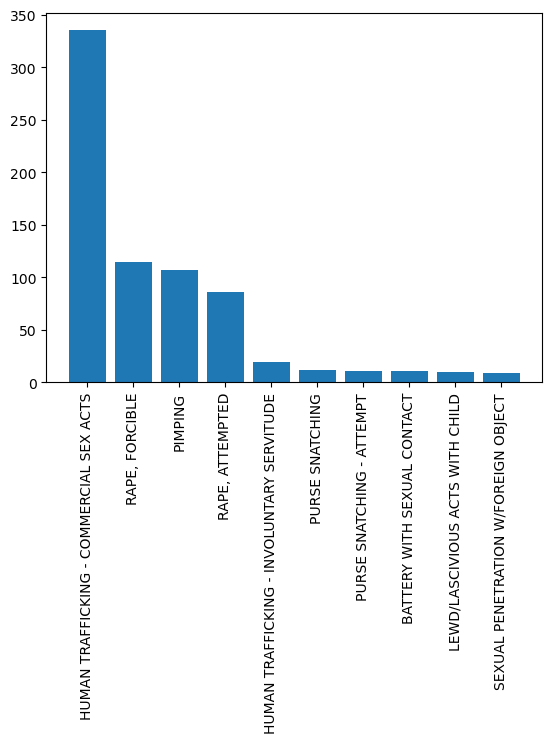

In [97]:
#combined_ratios = pd.concat([fm_ratio.sort_values(ascending=False)[0:5],mf_ratio.sort_values(ascending=False)[0:5]])
#combined_ratios[0:5].index
plt.bar(range(10),fm_ratio.sort_values(ascending=False)[0:10],tick_label=fm_ratio.sort_values(ascending=False)[0:10].index)
plt.xticks(rotation=90)
plt.show()

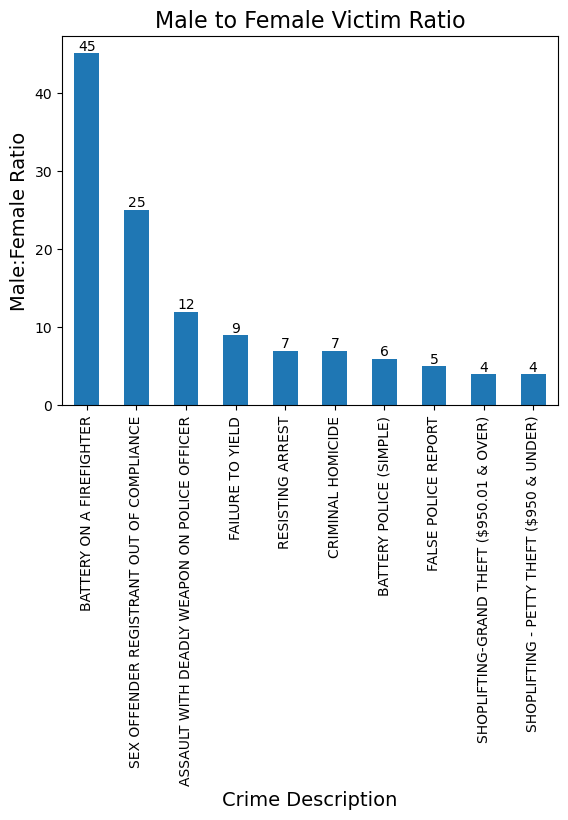

In [189]:
mf = round(mf_ratio.sort_values(ascending=False)[0:10])
mf_bar = mf.plot(kind='bar')
mf_bar.set_xticklabels(mf.index)
mf_bar.bar_label(mf_bar.containers[0], label_type='edge')
plt.xlabel('Crime Description',fontsize=14)
plt.ylabel('Male:Female Ratio',fontsize=14)
plt.title('Male to Female Victim Ratio',fontsize=16)
plt.savefig('mf_ratio.png',bbox_inches='tight')

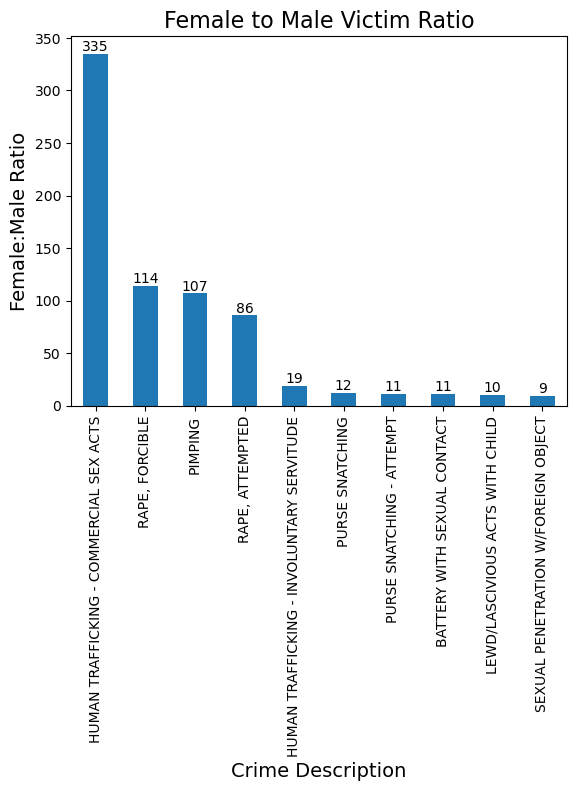

In [188]:
fm = round(fm_ratio.sort_values(ascending=False)[0:10])
fm_bar = fm.plot(kind='bar')
fm_bar.set_xticklabels(fm.index)
fm_bar.bar_label(fm_bar.containers[0], label_type='edge')
plt.xlabel('Crime Description',fontsize=14)
plt.ylabel('Female:Male Ratio',fontsize=14)
plt.title('Female to Male Victim Ratio',fontsize=16)
plt.savefig('fm_ratio.png',bbox_inches='tight')

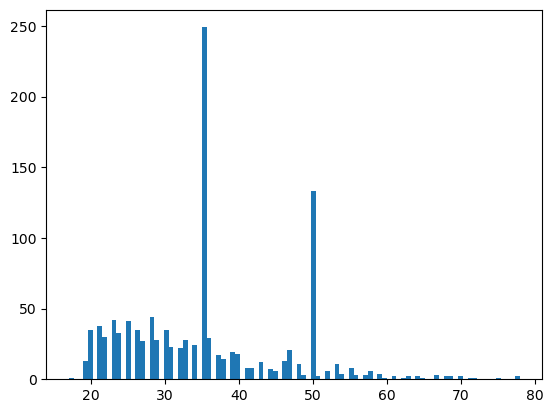

In [85]:
#Look at age by crime type of interest
#likely placeholder values for age (35,50)
plt.hist(age_sex_df.loc[age_sex_df['Crm Cd Desc'] == 'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)','Vict Age'],95)
plt.show()

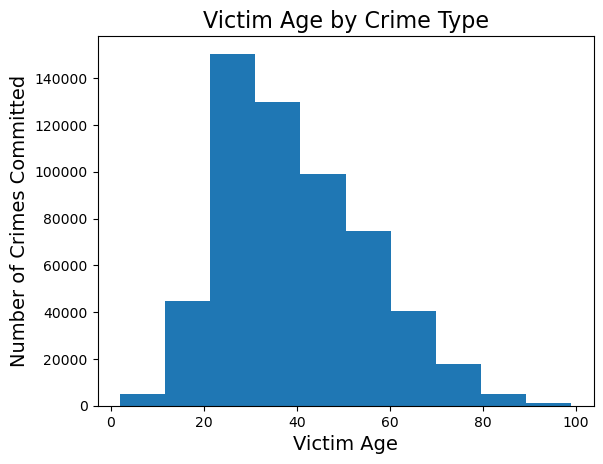

In [184]:
plt.hist(age_sex_df['Vict Age'], bins= 10)
plt.title('Victim Age by Crime Type',fontsize=16)
plt.xlabel('Victim Age',fontsize=14)
plt.ylabel('Number of Crimes Committed',fontsize=14)
plt.savefig('age.png')
plt.show()

In [8]:
bins = [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
time_labels = ['12 a.m.','1 a.m.','2 a.m.','3 a.m.','4 a.m.','5 a.m.','6 a.m.','7 a.m.','8 a.m.','9 a.m.','10 a.m.','11 a.m.','12 p.m.','1 p.m.','2 p.m.','3 p.m.','4 p.m.','5 p.m.','6 p.m.','7 p.m.','8 p.m.','9 p.m.','10 p.m.','11 p.m.']
standard_times = [crime_df['dt'][i].hour for i in range(len(crime_df))]
times = pd.cut(standard_times,bins,labels=time_labels,include_lowest=True)
crime_df['time'] = times

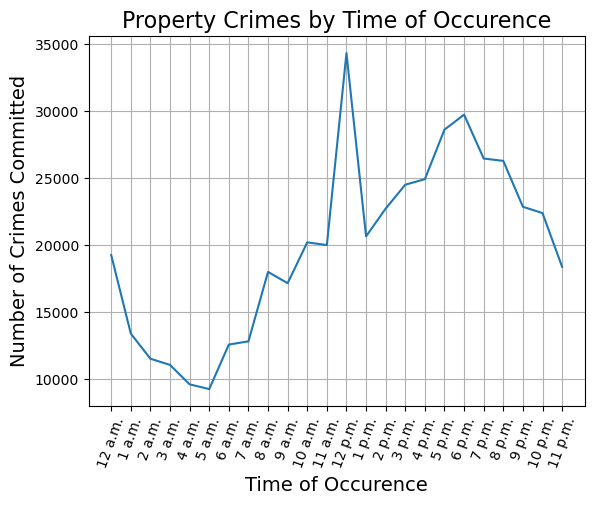

In [178]:
crime_type_df = crime_df[(crime_df['type'] == 'property')]
tvc = crime_type_df.groupby('time')['TIME OCC'].count()
plt.plot(tvc.index,tvc.values)
plt.xticks(rotation=70)
plt.grid()
plt.xlabel('Time of Occurence',fontsize=14)
plt.ylabel('Number of Crimes Committed',fontsize=14)
plt.title('Property Crimes by Time of Occurence',fontsize=16)
plt.savefig('property_time.png',bbox_inches='tight')
plt.show()

In [171]:
noon_crimes = crime_df[(crime_df['TIME OCC'] == 1400)]['Crm Cd Desc'].value_counts()
chi_df = pd.DataFrame({'expected':crime_df['Crm Cd Desc'].value_counts()[noon_crimes.index]*noon_crimes.sum()/crime_df['Crm Cd Desc'].value_counts()[noon_crimes.index].sum(),'observed':noon_crimes})
stats.chisquare(chi_df['observed'],chi_df['expected'])


Power_divergenceResult(statistic=1244.022838026942, pvalue=2.886602135308807e-197)

In [180]:
chi_df['ratio'] = chi_df['observed'] / chi_df['expected']
chi_df.sort_values('ratio',ascending=False)[0:50]

,expected,observed,ratio
"REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)",0.181091,1,5.522078
DISHONEST EMPLOYEE - GRAND THEFT,0.561383,2,3.562631
DISHONEST EMPLOYEE - PETTY THEFT,0.307855,1,3.248281
DOCUMENT WORTHLESS ($200.01 & OVER),0.941675,3,3.185814
PURSE SNATCHING,1.629821,5,3.067821
"BUNCO, PETTY THEFT",30.459549,84,2.757756
CHILD STEALING,6.446849,16,2.481833
"BUNCO, GRAND THEFT",87.847367,204,2.322210
"CREDIT CARDS, FRAUD USE ($950 & UNDER",1.394403,3,2.151459
"VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)",25.588194,50,1.954026


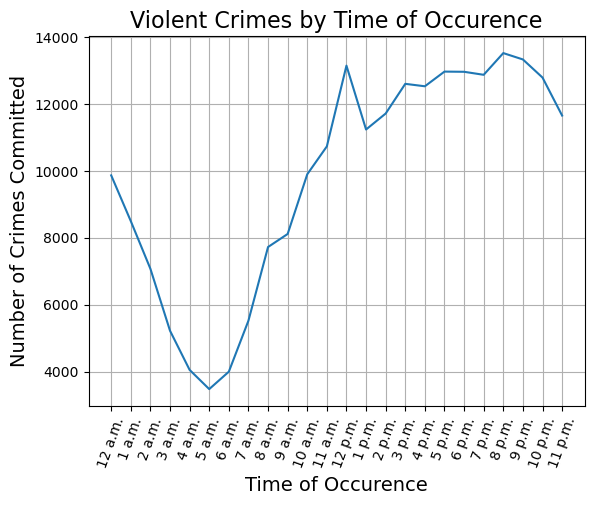

In [179]:
crime_type_df = crime_df[(crime_df['type'] == 'violent')]
tvc = crime_type_df.groupby('time')['TIME OCC'].count()
plt.plot(tvc.index,tvc.values)
plt.xticks(rotation=70)
plt.grid()
plt.xlabel('Time of Occurence',fontsize=14)
plt.ylabel('Number of Crimes Committed',fontsize=14)
plt.title('Violent Crimes by Time of Occurence',fontsize=16)
plt.savefig('violent_time.png',bbox_inches='tight')
plt.show()

In [9]:
#Add column for month to crime_df
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12]
month_number = [crime_df['dt'][i].month for i in range(len(crime_df))]
month_labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month = pd.cut(month_number, bins, labels=month_labels, include_lowest=True)
crime_df['month'] = month
#Add column for year
bins = [0,2020,2021,2022,2023]
year_labels=['2020','2021','2022','2023']
year_number = [crime_df['dt'][i].year for i in range(len(crime_df))]
year = pd.cut(year_number, bins, labels=year_labels, include_lowest=True)
crime_df['year'] = year

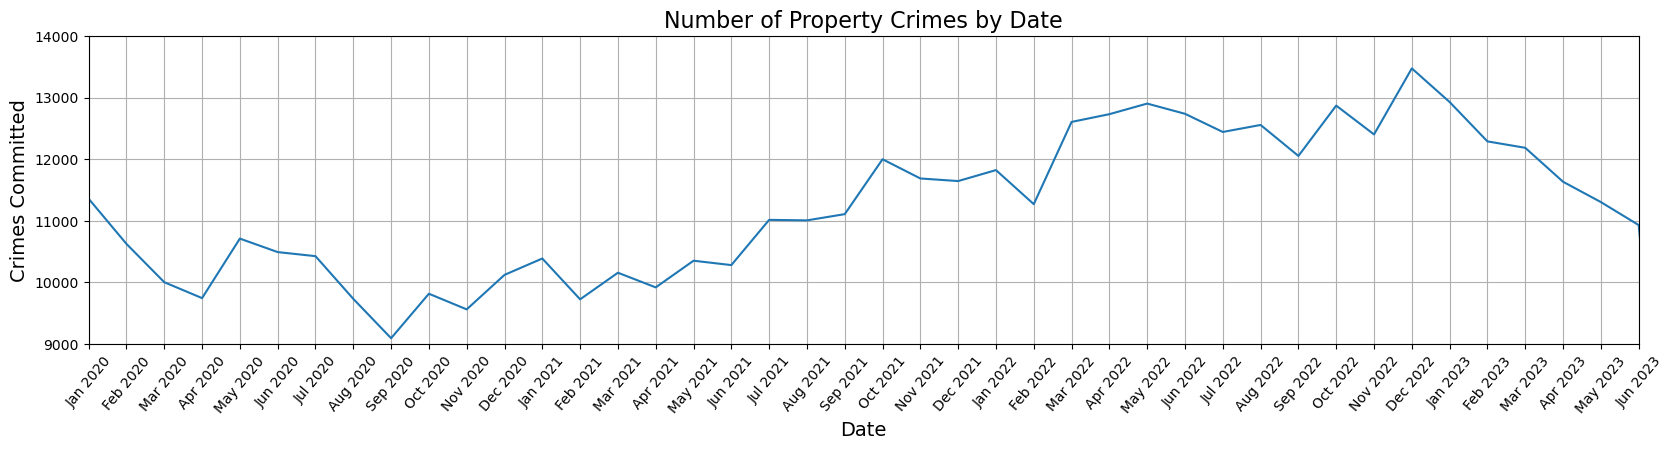

In [37]:
#create dataframe and plot for date(month and year) and number of property crimes
dates = []
crime_type_df = crime_df[(crime_df['type'] == 'property')]
date_counts = crime_type_df.groupby(['year','month'])['TIME OCC'].count()
for i in range(len(date_counts)):
    dates.append(f'{month_labels[i%12]} {year_labels[int(i/12)]}')
dvc = pd.DataFrame({'Date':dates,'Crimes':crime_type_df.groupby(['year','month'])['TIME OCC'].count().values})
dvc.plot(figsize=(20,4),grid=True,rot=50,legend=False)
plt.xticks(dvc.index,dvc['Date'])
plt.xlim((0,41))
plt.ylim((9000,14000))
plt.xlabel('Date',fontsize=14)
plt.ylabel('Crimes Committed',fontsize=14)
plt.title('Number of Property Crimes by Date',fontsize=16)
plt.savefig('property_month.png',bbox_inches='tight')
plt.show()


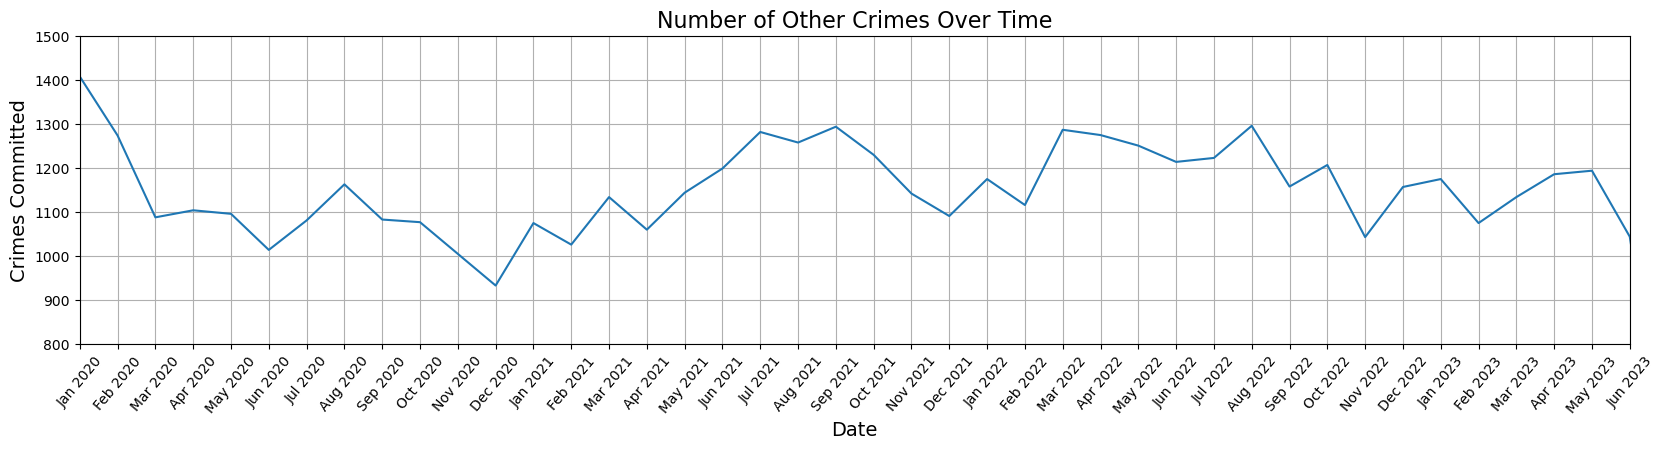

In [11]:
#create dataframe and plot for date(month and year) and number of other crimes
dates = []
crime_type_df = crime_df[(crime_df['type'] == 'other')]
date_counts = crime_type_df.groupby(['year','month'])['TIME OCC'].count()
for i in range(len(date_counts)):
    dates.append(f'{month_labels[i%12]} {year_labels[int(i/12)]}')
dvc = pd.DataFrame({'Date':dates,'Crimes':crime_type_df.groupby(['year','month'])['TIME OCC'].count().values})
dvc.plot(figsize=(20,4),grid=True,rot=50,legend=False)
plt.xticks(dvc.index,dvc['Date'])
plt.xlim((0,41))
plt.ylim((800,1500))
plt.xlabel('Date',fontsize=14)
plt.ylabel('Crimes Committed',fontsize=14)
plt.title('Number of Other Crimes Over Time',fontsize=16)
plt.show()


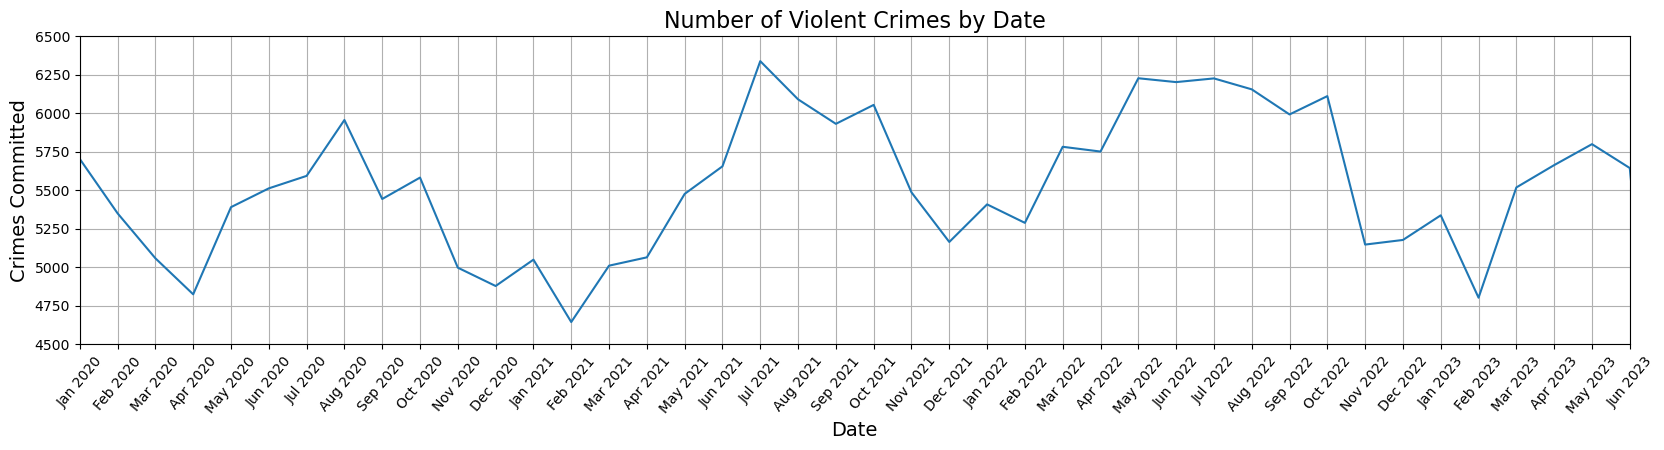

In [38]:
#create dataframe and plot for date(month and year) and number of violent crimes
dates = []
crime_type_df = crime_df[(crime_df['type'] == 'violent')]
date_counts = crime_type_df.groupby(['year','month'])['TIME OCC'].count()
for i in range(len(date_counts)):
    dates.append(f'{month_labels[i%12]} {year_labels[int(i/12)]}')
dvc = pd.DataFrame({'Date':dates,'Crimes':crime_type_df.groupby(['year','month'])['TIME OCC'].count().values})
dvc.plot(figsize=(20,4),grid=True,rot=50,legend=False)
plt.xticks(dvc.index,dvc['Date'])
plt.xlim((0,41))
plt.ylim((4500,6500))
plt.xlabel('Date',fontsize=14)
plt.ylabel('Crimes Committed',fontsize=14)
plt.title('Number of Violent Crimes by Date',fontsize=16)
plt.savefig('violent_month.png',bbox_inches='tight')
plt.show()

In [11]:
weekday = [crime_df['dt'][i].weekday() for i in range(len(crime_df))]

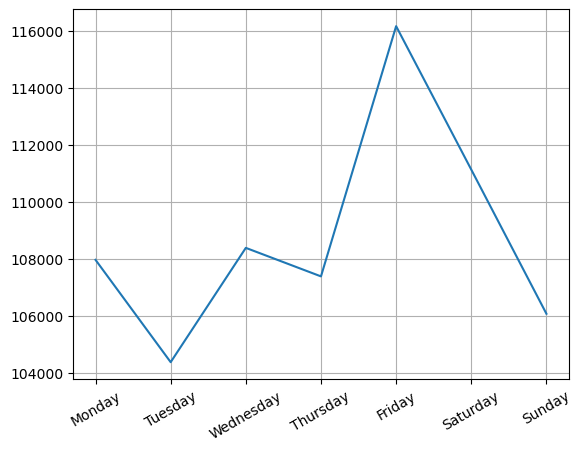

In [12]:
#create DataFrame for chi squared test on day of week
day_counts = {}
day_counts['Monday'] = weekday.count(0)
day_counts['Tuesday'] = weekday.count(1)
day_counts['Wednesday'] = weekday.count(2)
day_counts['Thursday'] = weekday.count(3)
day_counts['Friday'] = weekday.count(4)
day_counts['Saturday'] = weekday.count(5)
day_counts['Sunday'] = weekday.count(6)
day_tester = pd.DataFrame.from_dict(day_counts,orient='index')
day_avg = len(crime_df)/7
day_tester['expected'] = day_avg
day_tester.rename(columns={0:'observed'},inplace=True)
day_tester
stats.chisquare(day_tester['observed'],day_tester['expected'])
plt.plot(day_tester.index,day_tester['observed'])
plt.grid()
plt.xticks(rotation=30)
plt.show()


In [13]:
weekday_conversion = []
for i in range(len(weekday)):
    day_number = weekday[i]
    if day_number == 0:
        weekday_conversion.append('Monday')
    if day_number == 1:
        weekday_conversion.append('Tuesday')
    if day_number == 2:
        weekday_conversion.append('Wednesday')
    if day_number == 3:
        weekday_conversion.append('Thursday')
    if day_number == 4:
        weekday_conversion.append('Friday')
    if day_number == 5:
        weekday_conversion.append('Saturday')
    if day_number == 6:
        weekday_conversion.append('Sunday')

    
crime_df['weekday'] = weekday_conversion


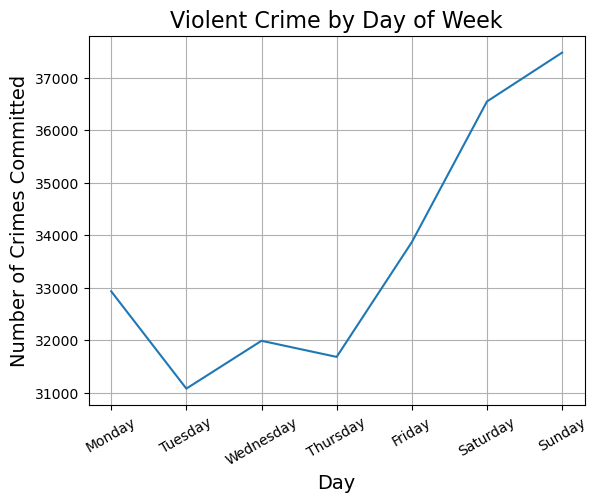

In [39]:
crime_type_df = crime_df[crime_df['type'] == 'violent']
wdvc = crime_type_df.groupby('weekday')['dt'].count()
wdvc2 = wdvc.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.plot(wdvc2.index,wdvc2.values)
plt.xticks(rotation=30)
plt.xlabel('Day',fontsize=14)
plt.ylabel('Number of Crimes Committed',fontsize = 14)
plt.title('Violent Crime by Day of Week',fontsize=16)
plt.grid()
plt.savefig('violent_day.png',bbox_inches='tight')
plt.show()


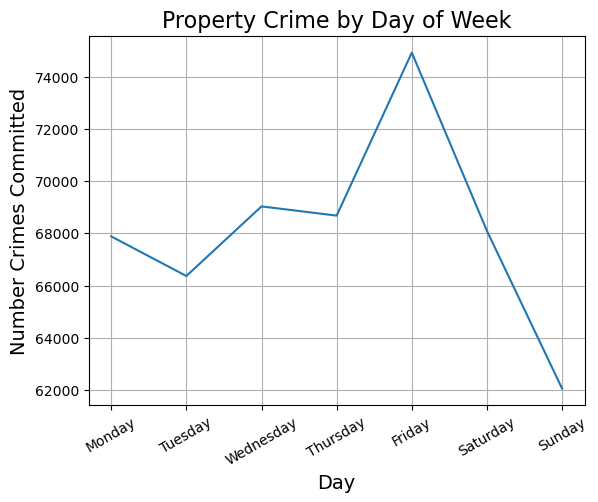

In [40]:
crime_type_df = crime_df[crime_df['type'] == 'property']
wdvc = crime_type_df.groupby('weekday')['dt'].count()
wdvc2 = wdvc.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.plot(wdvc2.index,wdvc2.values)
plt.xticks(rotation=30)
plt.xlabel('Day',fontsize=14)
plt.ylabel('Number Crimes Committed',fontsize = 14)
plt.title('Property Crime by Day of Week',fontsize=16)
plt.grid()
plt.savefig('property_day.png',bbox_inches='tight')
plt.show()

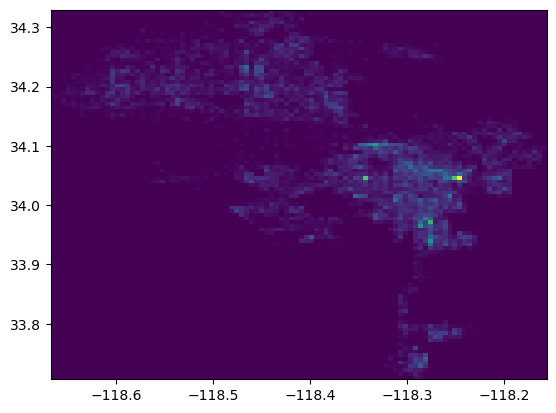

In [42]:
#crimes by location
crime_df_loc = crime_df[(crime_df['LAT'] != 0) & (crime_df['LON'] != 0)]
crime_df_type = crime_df_loc[crime_df_loc['type'] == 'other']
plt.hist2d(crime_df_type['LON'],crime_df_type['LAT'],bins=(100,100))
#plt.xlim(-118.4,-118.2)
#plt.ylim(33.9,34.15)
plt.show()
#violent crime more concentrated

In [63]:

bokeh_width, bokeh_height = 550,400
def plot(df,lat, lng, zoom=10, map_type='roadmap'):


    gmap_options = GMapOptions(lat=lat, lng=lng, 
                               map_type=map_type, zoom=zoom)
    tooltips = [('Area', '@area')]
    p = gmap(gmaps_api_key, gmap_options, title='Los Angeles', 
             width=bokeh_width, height=bokeh_height, 
             tools=['hover','reset', 'wheel_zoom', 'pan'],tooltips=tooltips)
    source = ColumnDataSource(df)

    mapper = linear_cmap(field_name='count', palette=palette, low = df['count'].min(),high = df['count'].max())    
    # we use the mapper for the color of the circles
    center = p.circle('lon','lat', size=10, alpha=1, color=mapper,source=source)
    # and we add a color scale to see which values the colors 
    color_bar = ColorBar(color_mapper=mapper['transform'], 
                         location=(0,0))
   
    
    show(p)
    return p

In [43]:
area_lat = crime_df_loc.groupby('AREA NAME')['LAT'].mean()
area_lon = crime_df_loc.groupby('AREA NAME')['LON'].mean()
area_count = crime_df_loc.groupby('AREA NAME')['AREA'].count()
loc_df = pd.DataFrame({'lat':area_lat,'lon':area_lon,'count':area_count,'area':area_count.index})
area_count.index

Index(['77th Street', 'Central', 'Devonshire', 'Foothill', 'Harbor',
       'Hollenbeck', 'Hollywood', 'Mission', 'N Hollywood', 'Newton',
       'Northeast', 'Olympic', 'Pacific', 'Rampart', 'Southeast', 'Southwest',
       'Topanga', 'Van Nuys', 'West LA', 'West Valley', 'Wilshire'],
      dtype='object', name='AREA NAME')

In [45]:
crime_df_loc['LAT'].max() - crime_df_loc['LAT'].min()
crime_df_loc['LON'].max() - crime_df_loc['LON'].min()
crime_df_loc['LON'].min()
#.63,.51; 33.7, -118.67
loc_df

,lat,lon,count,area
AREA NAME,,,,
77th Street,33.977698,-118.297208,48031,77th Street
Central,34.047410,-118.250539,50920,Central
Devonshire,34.249995,-118.539190,30762,Devonshire
Foothill,34.248836,-118.378283,25491,Foothill
Harbor,33.771752,-118.285281,31524,Harbor
Hollenbeck,34.054452,-118.203201,28563,Hollenbeck
Hollywood,34.099405,-118.329826,40201,Hollywood
Mission,34.255943,-118.450664,30229,Mission
N Hollywood,34.171456,-118.384705,37800,N Hollywood


In [106]:
lat, lon = 34.1, -118.4
p = plot(loc_df,lat, lon)
#save(p,filename='crime_locations.png')


0:73: execution error: An error of type -10673 has occurred. (-10673)
